# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=d078821de3516e22ac9198863204290e4f3457dd715e680461c1a744b4269e3d
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=a5fa01f398829506c5372010a39f036d086c62babcc787902e0c5250b30d923d
  Stored in directory: /root/.cache/pip/w

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 26.94 MiB/s, done.
Resolving deltas: 100% (3/3), done.


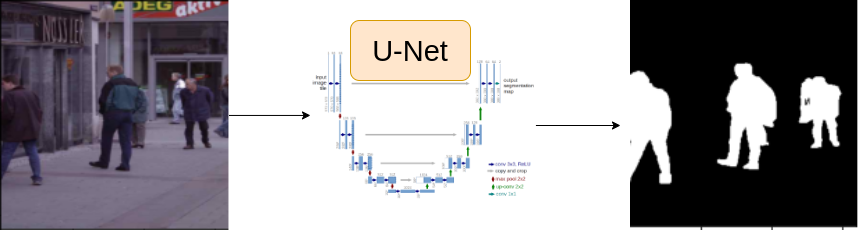

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_PATH="/content/Human-Segmentation-Dataset-master/train.csv"
DIR_PATH="/content/"
DEVICE="cuda"
EPOCHS=25
LR=0.01
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER='timm-efficientnet-b0'
WEIGHT='imagenet'

In [ ]:
df=pd.read_csv(CSV_PATH)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row=df.iloc[3]
image_path=row.images
mask_path=row.masks 
image=cv2.imread(image_path)
image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

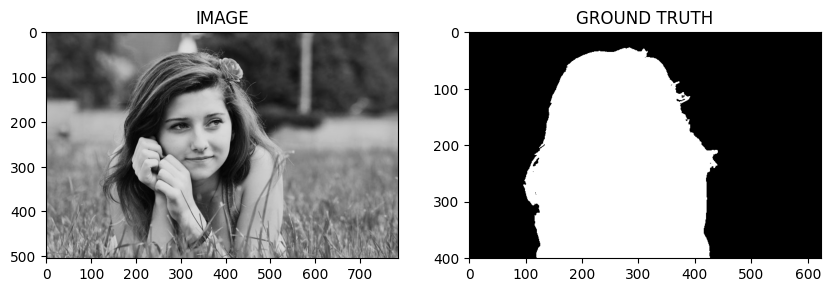

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df=train_test_split(df,test_size=0.2,random_state=42)
print(train_df.shape)
print(valid_df.shape)

(232, 2)
(58, 2)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
  ],is_check_shapes=False)
def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE,IMAGE_SIZE),
  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset


In [ ]:
class SegmentationData(Dataset):
  def __init__(self,df,augmentations):
    self.df = df
    self.augmentations=augmentations
  def __len__(self):
    return len(self.df)
  def __getitem__(self,idx):
    row=df.iloc[idx]
    image_path=row.images
    mask_path=row.masks 
    image=cv2.imread(image_path)
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    mask=cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
    mask=np.expand_dims(mask,axis=-1)
    if self.augmentations:
      data=self.augmentations(image=image,mask=mask)
      image=data['image']
      mask=data['mask']
    image=np.transpose(image,(2,0,1)).astype(np.float32)
    mask=np.transpose(mask,(2,0,1)).astype(np.float32)
    

    image=torch.Tensor(image)/255.0
    mask=torch.round(torch.Tensor(mask)/255.0)
    return image,mask

In [ ]:
trainset=SegmentationData(train_df,get_train_augs())
validset=SegmentationData(valid_df,get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


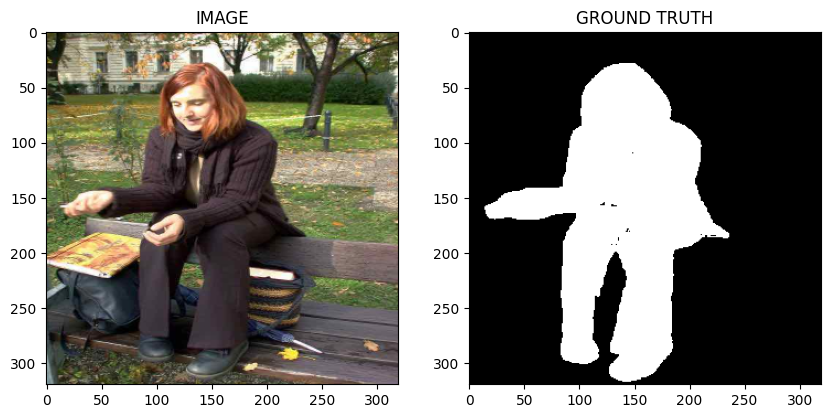

In [ ]:
idx=32
image,mask=trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
validloader=DataLoader(validset,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
print(len(trainloader))
print(len(validloader))

15
4


In [ ]:
for  image,mask in trainloader:
  print(image.shape)
  print(mask.shape)
  break

torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model
segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
from torchvision.models.densenet import Weights
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel,self).__init__()
    self.arc=smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=WEIGHT,
        in_channels=3,
        classes=1,
        activation=None
    )
  def forward(self,images,masks=None):
       logits=self.arc(images)
       if masks !=None:
         loss1=DiceLoss(mode="binary")(logits,masks)
         loss2=nn.BCEWithLogitsLoss()(logits,masks)
       return logits,loss1+loss2

In [ ]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function 

In [ ]:

def train_fn(data_loader,model,optimizer):
    model.train()
    total_loss=0.0
    for image,masks in tqdm(data_loader):
      image=image.to(DEVICE)
      masks=masks.to(DEVICE)
      optimizer.zero_grad()
      logits,loss=model(image,masks)
      loss.backward()
      optimizer.step
      total_loss+=loss.item()
    return total_loss/len(data_loader)


In [ ]:
def eval_fn(data_loader,model):
    model.eval()
    total_loss=0.0
    with torch.no_grad():
      for image,masks in tqdm(data_loader):
        image=image.to(DEVICE)
        masks=masks.to(DEVICE)
        logits,loss=model(image,masks)
        total_loss+=loss.item()
    return total_loss/len(data_loader)


# Task 8 : Train Model

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss=np.Inf
for i in range(EPOCHS):
  train_loss=train_fn(trainloader,model,optimizer)
  valid_loss=eval_fn(validloader,model)
  if valid_loss <best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print('MODEL_SAVED')
    best_valid_loss=valid_loss

100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


MODEL_SAVED


100%|██████████| 4/4 [00:00<00:00,  4.50it/s]


MODEL_SAVED


100%|██████████| 4/4 [00:00<00:00,  5.75it/s]


# Task 9 : Inference

In [ ]:
idx=20
model.load_state_dict(torch.load('/content/best_model.pt'))
image,mask=validset[idx]
logits_mask=model(image.to(DEVICE).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask>0.5)*1.0

UnboundLocalError: ignored

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya